# Отток клиентов

## Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.
Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.
Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

**Цель проекта** - построить модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверить F1-меру на тестовой выборке.
Дополнительно измерять AUC-ROC, сравнивать её значение с F1-мерой.

**Ход работы**

Данные оклиентах получаем из файла `/datasets/Churn.csv`.

Работа пройдет в несколько этапов:
* Подготовка данных
* Исследование баланса классов
* Улучшение качества модели
* Финальное тестирование

**Описание данных**

Признаки
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

Целевой признак
* Exited — факт ухода клиента

## Шаг 1. Подготовка данных

Импортируем нужные модули

In [2]:
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
RANDOM_STATE = 12345

Получим данные из датасета

In [5]:
try:
    data = pd.read_csv('../../datasets/Churn.csv')
except FileNotFoundError:
    data = pd.read_csv('/datasets/Churn.csv')

Посмотрим на данные

In [6]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Для удобства, приведем названия столбцов к нижнему регистру

In [7]:
data.columns = data.columns.str.lower()

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           9091 non-null   float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Есть пропуски в столбце `tenure`. Так как нет корректного способа узнать природу этих пропусков, то лучше их удалить

In [9]:
data.dropna(axis=0, inplace=True)

Так же, в датасете есть столбцы, которые никак нам не помогут в исследовании: `rownumber`, `customerid`, `surname`. Удалим их

In [10]:
data.drop(['rownumber', 'customerid', 'surname'], axis=1, inplace=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      9091 non-null   int64  
 1   geography        9091 non-null   object 
 2   gender           9091 non-null   object 
 3   age              9091 non-null   int64  
 4   tenure           9091 non-null   float64
 5   balance          9091 non-null   float64
 6   numofproducts    9091 non-null   int64  
 7   hascrcard        9091 non-null   int64  
 8   isactivemember   9091 non-null   int64  
 9   estimatedsalary  9091 non-null   float64
 10  exited           9091 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 852.3+ KB


Закодируем категориальные признаки техникой OHE

In [12]:
data_ohe = pd.get_dummies(data, drop_first=True)

In [13]:
data_ohe.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Разделим данные на цели и признаки

In [14]:
features = data_ohe.drop('exited', axis=1)
target = data_ohe['exited']

Разделим данные на тренировочную, валидационную и тестовую выборки в соотношении 6:2:2

In [15]:
X_train, X, y_train, y = train_test_split(features, target, test_size=.4, stratify=target, random_state=RANDOM_STATE)
X_valid, X_test, y_valid, y_test = train_test_split(X, y, test_size=.5, stratify=y, random_state=RANDOM_STATE)
print(X_train.shape)
print()
print(y_train.shape)
print('----------------------------------------------------------------------')
print(X_valid.shape)
print()
print(y_valid.shape)
print('----------------------------------------------------------------------')
print(X_test.shape)
print()
print(y_test.shape)
print('----------------------------------------------------------------------')

(5454, 11)

(5454,)
----------------------------------------------------------------------
(1818, 11)

(1818,)
----------------------------------------------------------------------
(1819, 11)

(1819,)
----------------------------------------------------------------------


Масштабируем численные признаки

In [18]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

## Шаг 2. Исследование баланса классов

### Шаг 2.1. Исследуем баланс классов

Посмотрим, есть ли дисбаланс классов

In [ ]:
data_ohe_zeros = data_ohe.query('exited == 0')
data_ohe_ones = data_ohe.query('exited == 1')
print(data_ohe_zeros.shape)
print(data_ohe_ones.shape)

Видим, что положительных элементов почти в 4 раза больше, чем отрицательных

### Шаг 2.2. Обучим модели на несбалансированных данных

Видим, что положительных элементов почти в 4 раза больше, чем отрицательных

### Шаг 2.2. Обучим модели на несбалансированных данных

Иccледуем характеристики моделей без учета баланса классов. Для этого обучим модели логистической регрессии, случайного леса и решающего дерева на тестовой выборке и посчитаем метрики F1 и AUC-ROC

Для удобства и соблюдения принципа DRY напишем функцию для вычисления и вывода метрик `F1` и `ROC-AUC`

In [20]:
def f1_roc_auc(model, X_val, y_val, y_pred):
    print(f'F1 score: {f1_score(y_val, y_pred)}')
    prob = model.predict_proba(X_val)
    roc_auc = roc_auc_score(y_val, prob[:, 1])
    print(f'ROC-AUC score: {roc_auc}')

Дерево решений

In [21]:
dec_tree_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
dec_tree_model.fit(X_train, y_train)
y_predicted = dec_tree_model.predict(X_valid)
f1_roc_auc(dec_tree_model, X_valid, y_valid, y_predicted)

F1 score: 0.4919786096256685
ROC-AUC score: 0.6812887338242334


Логистическая регрессия

In [22]:
log_reg_model = LogisticRegression(random_state=RANDOM_STATE)
log_reg_model.fit(X_train, y_train)
y_predicted = log_reg_model.predict(X_valid)
f1_roc_auc(log_reg_model, X_valid, y_valid, y_predicted)

F1 score: 0.3306772908366534
ROC-AUC score: 0.7893382907660986


Случайный лес

In [23]:
rand_forest_model = RandomForestClassifier(random_state=RANDOM_STATE)
rand_forest_model.fit(X_train, y_train)
y_predicted = rand_forest_model.predict(X_valid)
f1_roc_auc(dec_tree_model, X_valid, y_valid, y_predicted)

F1 score: 0.5957446808510638
ROC-AUC score: 0.6812887338242334


Лучшие показатели у модели случайного леса

## Шаг 3. Улучшение качества модели

Посмотрим на поведение моделей с параметром `class_weight='balanced'` и подберем гиперпараметры

### Дерево решений

In [24]:
dec_tree_model = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')
dec_tree_model.fit(X_train, y_train)
y_predicted = dec_tree_model.predict(X_valid)
f1_roc_auc(dec_tree_model, X_valid, y_valid, y_predicted)

F1 score: 0.5161290322580645
ROC-AUC score: 0.6962169150039956


Подберем гиперпараметры

In [25]:
params = {
    'max_depth': range(1, 30),
}
grid = GridSearchCV(dec_tree_model, params, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 29 candidates, totalling 145 fits


GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=12345),
             param_grid={'max_depth': range(1, 30)}, verbose=1)

In [26]:
grid.best_params_

{'max_depth': 20}

Обучим модель с полученными гиперпараметрами

In [27]:
dec_tree_model = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced', max_depth=20)
dec_tree_model.fit(X_train, y_train)
y_predicted = dec_tree_model.predict(X_valid)
f1_roc_auc(dec_tree_model, X_valid, y_valid, y_predicted)

F1 score: 0.5161290322580645
ROC-AUC score: 0.6962169150039956


### Логистическая регрессия

In [28]:
log_reg_model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', solver='liblinear')
log_reg_model.fit(X_train, y_train)
y_predicted = log_reg_model.predict(X_valid)
f1_roc_auc(log_reg_model, X_valid, y_valid, y_predicted)

F1 score: 0.5065420560747663
ROC-AUC score: 0.790763304317698


Подберем гиперпараметры

In [29]:
params = {
    'penalty': ['l1', 'l2'],
    'C': [1, 5, 10],
}
grid = GridSearchCV(log_reg_model, params, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          random_state=12345,
                                          solver='liblinear'),
             param_grid={'C': [1, 5, 10], 'penalty': ['l1', 'l2']}, verbose=1)

In [30]:
grid.best_params_

{'C': 1, 'penalty': 'l1'}

Обучим модель с полученными гиперпараметрами

In [31]:
log_reg_model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', solver='liblinear', penalty='l1')
log_reg_model.fit(X_train, y_train)
y_predicted = log_reg_model.predict(X_valid)
f1_roc_auc(log_reg_model, X_valid, y_valid, y_predicted)

F1 score: 0.5065420560747663
ROC-AUC score: 0.7907782064201982


### Случайный лес

In [32]:
rand_forest_model = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
rand_forest_model.fit(X_train, y_train)
y_predicted = rand_forest_model.predict(X_valid)
f1_roc_auc(rand_forest_model, X_valid, y_valid, y_predicted)

F1 score: 0.570940170940171
ROC-AUC score: 0.8689062043040998


Подберем гиперпараметры

In [33]:
clf = RandomForestClassifier(random_state=RANDOM_STATE)
params = {
    'n_estimators': range(1, 100),
    'max_depth': range(1, 30),
}
search = RandomizedSearchCV(clf, params, verbose=1, random_state=RANDOM_STATE)
search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=RandomForestClassifier(random_state=12345),
                   param_distributions={'max_depth': range(1, 30),
                                        'n_estimators': range(1, 100)},
                   random_state=12345, verbose=1)

In [34]:
search.best_params_

{'n_estimators': 91, 'max_depth': 9}

Обучим модель с полученными гиперпараметрами

In [35]:
rand_forest_model = RandomForestClassifier(n_estimators=91, max_depth=9, random_state=RANDOM_STATE, class_weight='balanced')
rand_forest_model.fit(X_train, y_train)
y_predicted = rand_forest_model.predict(X_valid)
f1_roc_auc(rand_forest_model, X_valid, y_valid, y_predicted)

F1 score: 0.639386189258312
ROC-AUC score: 0.8754016582314557


Качество предсказаний повысилось за счет балансировки весов классов и подходящих гиперпараметров

Используем `upsampling` для выравнивания баланса классов

In [36]:
X_train_zeros = X_train[y_train == 0]
X_train_ones = X_train[y_train == 1]
y_train_zeros = y_train[y_train == 0]
y_train_ones = y_train[y_train == 1]
print(X_train_zeros.shape)
print(X_train_ones.shape)
print(y_train_zeros.shape)
print(y_train_ones.shape)

(4342, 11)
(1112, 11)
(4342,)
(1112,)


In [37]:
X_train_upsampled = pd.concat([X_train_zeros] + [X_train_ones] * 4)
y_train_upsampled = pd.concat([y_train_zeros] + [y_train_ones] * 4)
X_train_upsampled, y_train_upsampled = shuffle(X_train_upsampled, y_train_upsampled, random_state=RANDOM_STATE)

Проверим метрики моделей на сбалансированной выборке

Дерево решений

In [38]:
dec_tree_model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=20)
dec_tree_model.fit(X_train_upsampled, y_train_upsampled)
y_predicted = dec_tree_model.predict(X_valid)
f1_roc_auc(dec_tree_model, X_valid, y_valid, y_predicted)

F1 score: 0.5245033112582781
ROC-AUC score: 0.7025754558646293


Логистическая регрессия

In [39]:
log_reg_model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')
log_reg_model.fit(X_train_upsampled, y_train_upsampled)
y_predicted = log_reg_model.predict(X_valid)
f1_roc_auc(log_reg_model, X_valid, y_valid, y_predicted)

F1 score: 0.5050878815911193
ROC-AUC score: 0.7908061478623865


Случайный лес

In [40]:
rand_forest_model = RandomForestClassifier(n_estimators=91, max_depth=9, random_state=RANDOM_STATE)
rand_forest_model.fit(X_train_upsampled, y_train_upsampled)
y_predicted = rand_forest_model.predict(X_valid)
f1_roc_auc(rand_forest_model, X_valid, y_valid, y_predicted)

F1 score: 0.6319444444444444
ROC-AUC score: 0.8765602967008608


`Upsampling` дал небольшой прирост качества предсказаний. Лучшие показатели у модели случайного леса, поэтому в дальнейшем будем использовать ее

## Шаг 4. Финальное тестирование

Объединим тренировочную и валидационную выборки

In [41]:
X_total_train = pd.concat([X_train_upsampled,X_valid])
y_total_train = pd.concat([y_train_upsampled, y_valid])
X_total_train = shuffle(X_total_train, random_state=RANDOM_STATE)
y_total_train = shuffle(y_total_train, random_state=RANDOM_STATE)

Обучим модель случайного леса с полученными гиперпараметрами на объединенных тренировочных данных и посмотрим метрики на тестовой выборке

In [42]:
model = RandomForestClassifier(n_estimators=91, max_depth=9, random_state=RANDOM_STATE)
model.fit(X_total_train, y_total_train)
predict = model.predict(X_test)
f1_roc_auc(model, X_test, y_test, predict)

F1 score: 0.608233731739708
ROC-AUC score: 0.8544139327783651


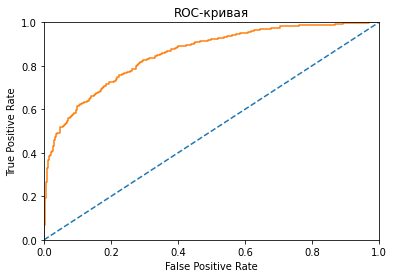

In [39]:
probabilities_valid = model.predict_proba(X_test)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_valid)

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()

## Итоговый вывод

В данной работе проведено исследование задачи оттока клиентов банка. Проведена подготовка и предобработка данных. Построены модели дерева решений, логистической регрессии и случайного леса, исследовано влияние дисбаланса классов на предсказания модели, подобраны гиперпараметры, посчитаны метрики F1 и AUC-ROC. Лучшие показатели получились у модели случайного леса - F1=0.608 (на тестовой выборке), что больше чем 0.59 (по условию задачи). 